# Evaluation of the Top classifier

This is the evaluation script of the top classifier in the hierarchy of three classifiers. The top classifier outputs a vector of size 2.

The two indices of the vector are the scores that the classifier has calculated based on one 5-second audio clip.

The first indice (0th) is the score/probability that the audio clip is of the Happy/Angry class.

The second indice (1st) is the score/probability that the audio clip is of the Neutral/Sad class.

### library and package importation

In [38]:
import random
import os
import shutil
import glob
import gc
import sys
import h5py
import time
import datetime
import pickle
import librosa
import warnings
import matplotlib.pyplot as plt

from graphs import draw
import graphs

import numpy as np
from numpy import array
import pandas as pd
from pandas.plotting import parallel_coordinates
from pydub import AudioSegment

#imported for testing
import wave
import contextlib

# for outputing file
from scipy.cluster.vq import vq, kmeans, whiten
import scipy.stats.stats as st

from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize
from sklearn.metrics import auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight

import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.constraints import maxnorm
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Add, Dropout, Input, Activation
from keras.layers import TimeDistributed, Bidirectional, LSTM, LeakyReLU
from keras.models import Sequential
from keras.models import load_model
from keras import optimizers, regularizers
from keras.utils import np_utils, to_categorical

from IPython.display import clear_output

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
# print(len(backend.tensorflow_backend._get_available_gpus()) > 0)

sample_rate=44100
hop_length = 441  # frame size= 2*hop
segment_length=int(sample_rate*0.2)  #0.2
segment_pad=int(sample_rate*0.02)     #0.02
overlappiong=int(sample_rate*0.1)   #0.1

NumofFeaturetoUse = 272 # this will re-assigned for different classifiers
frame_number = 48

sys.path.insert(1, '..//components//')
import load_feat_directories

# input new indices file here
# indices_filename = 'D://indices_filename.npy'
# indices=np.load(indices_filename)

In [39]:
def avail_modules(directory, prefix):
    module_names = []
    for item in os.listdir(directory):
        if prefix in item:
            module_names.append(directory + item)
            i = module_names.index(directory + item)
            print(str(i) + 'th module')
            print(directory + item)
    return module_names

In [40]:
def comprise_vector(path, dist, reverb, noise):
    vec_to_return = []
    for fname in os.listdir(path):
        components = fname.split('_')
        '''
        if dist == 0 and 'deamp' in components: continue
        if reverb == 0 and 'WetDry' in components: continue
        if noise == 0 and 'noise' in components: continue
        '''
        current_vec = np.load(path + fname)
        vec_to_return.append(current_vec)
        
    vec_to_return = np.array(vec_to_return)
    return vec_to_return

In [41]:
def comprise_label(feature_vector, label):
    label_vec_to_ret = []
    length = len(list(feature_vector))
    for index in range(0, length):
        current_label = [label]
        label_vec_to_ret.append(current_label)
    label_vec_to_ret = np.array(label_vec_to_ret)

    return label_vec_to_ret

def float_compatible(input_np):

    x = np.where(input_np >= np.finfo(np.float32).max)
    for index in range(0, len(x[0])):
        x_position = x[0][index]
        y_position = x[1][index]
        input_np[x_position, y_position] = 0.0
    input_np = np.nan_to_num(input_np)

    return input_np

def update_progress(progress):
    bar_length = 100
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [42]:
# allnoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
# homenoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
all_noised_npy = load_feat_directories.allnoised_npy
all_noised_npy_test = load_feat_directories.allnoised_npy_test
home_noised_npy = load_feat_directories.homenoised_npy
home_noised_npy_test = load_feat_directories.homenoised_npy_test

for index in range(0, 5):
    if not os.path.exists(home_noised_npy_test[index]):
        print(home_noised_npy_test[index] + 'does not exist. Breaking the loop... ')

In [43]:
emotions = [0, 1, 2, 3, 4]
home_or_all = 'home'
dist = 0
reverb = 0
noise = 0

for index in emotions:
    if home_or_all == 'home':
        path = home_noised_npy_test[index]
    else:
        path = all_noised_npy_test[index]
        
    if index == 0:
        val_h_feat = comprise_vector(path, dist, reverb, noise)
        val_h_label = comprise_label(val_h_feat, index)
    elif index == 1:
        val_a_feat = comprise_vector(path, dist, reverb, noise)
        val_a_label = comprise_label(val_a_feat, index)
    elif index == 2:
        val_n_feat = comprise_vector(path, dist, reverb, noise)
        val_n_label = comprise_label(val_n_feat, index)
    elif index == 3:
        val_s_feat = comprise_vector(path, dist, reverb, noise)
        val_s_label = comprise_label(val_s_feat, index)
    else:
        val_o_feat = comprise_vector(path, dist, reverb, noise)
        val_o_label = comprise_label(val_o_feat, index)     


In [44]:
print(val_h_feat.shape)
print(val_h_label.shape)

print(val_a_feat.shape)
print(val_a_label.shape)

print(val_n_feat.shape)
print(val_n_label.shape)

print(val_s_feat.shape)
print(val_s_label.shape)

print(val_o_feat.shape)
print(val_o_label.shape)

(1966, 48, 272)
(1966, 1)
(1942, 48, 272)
(1942, 1)
(1696, 48, 272)
(1696, 1)
(1947, 48, 272)
(1947, 1)
(1292, 48, 272)
(1292, 1)


# Other vs Target Emotions (Binary)

In [45]:
def other_eval_all(emotionFolders, val):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:

        for emotionfile in os.listdir(emotionFolder):
            
            one_sample = np.load(emotionFolder + emotionfile)
            one_sample = np.array([one_sample])
            zero_score, one_score = model.predict(one_sample)[0]
            zero_scores.append(zero_score)
            one_scores.append(one_score)

            if val == 0:
                if zero_score > one_score: correct += 1
                else: incorrect += 1
            else:
                if one_score > zero_score: correct += 1
                else: incorrect += 1

            total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [47]:
def other_eval_original(emotionFolders, val):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    correct = 0
    incorrect = 0

    for emotionfile in os.listdir(emotionFolder):
        dist = 'deamp_' in emotionfile
        reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
        noise = 'noise_' in emotionfile

        r_n = not dist and reverb and noise 
        r = not dist and reverb and not noise
        n = not dist and not reverb and noise
        original = not dist and not reverb and not noise
        d_r_n = dist and reverb and noise
        d_r = dist and reverb and not noise
        d_n = dist and not reverb and noise
        d = dist and not reverb and not noise 

        if original:
            one_sample = np.load(emotionFolder + emotionfile)
            one_sample = np.array([one_sample])
            zero_score, one_score = model.predict(one_sample)[0]
            zero_scores.append(zero_score)
            one_scores.append(one_score)

            if val == 0:
                if zero_score > one_score: correct += 1
                else: incorrect += 1
            else:
                if one_score > zero_score: correct += 1
                else: incorrect += 1

            total += 1
    
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [48]:
def other_eval_deamplified_noised(emotionFolders, val):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_n:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                components = emotionfile.split('_')
                deamplified_amount_position = components.index('deamp') + 1
                deamplified = float(components[deamplified_amount_position])
                deamplified_dbs.append(deamplified)
                
                zero_score, one_score = model.predict(one_sample)[0]
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [49]:
def other_eval_reverbed(emotionFolders, val):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []

    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if r:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                zero_score, one_score = model.predict(one_sample)[0]
                
                components = emotionfile.split('_')
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [50]:
def other_eval_deamplified_noised_reverbed(emotionFolders, val):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_r_n:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                zero_score, one_score = model.predict(one_sample)[0]
                
                components = emotionfile.split('_')
                
                deamplified_position = components.index('deamp') + 1
                deamplified_dbs.append(float(components[deamplified_position]))
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total))
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors,
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [51]:
def predict_cnn(model):
    y_pred = []
    y_true = []

    for item in list(Label_val):
            if item[0] > item[1]:
                y_true.append(0)
            elif item[0] < item[1]:
                y_true.append(1)
            else:
                y_true.append(0)

    for item in list(model.predict(featureSet_val)):
            if item[0] > item[1]:
                y_pred.append(0)
            elif item[0] < item[1]:
                y_pred.append(1)
            else:
                y_pred.append(0)

    print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
    print('Precision: ' + str(precision_score(y_true, y_pred)))
    print('Recall: ' + str(recall_score(y_true, y_pred)))
    print('f1 score: ' + str(f1_score(y_true, y_pred)))

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print('true positive ' + str(tp))
    print('false positive ' + str(fp))
    print('false negative ' + str(fn))
    print('true negative ' + str(tn))

In [52]:
h_index_val = random.sample(range(len(val_h_feat)), 325)
a_index_val = random.sample(range(len(val_a_feat)), 325)
n_index_val = random.sample(range(len(val_n_feat)), 325)
s_index_val = random.sample(range(len(val_s_feat)), 325)

target_feats_val = []
target_labels_val = []

for index in h_index_val:
    target_feats_val.append(val_h_feat[index])
    target_labels_val.append(val_h_label[index])
        
for index in a_index_val:
    target_feats_val.append(val_a_feat[index])
    target_labels_val.append(val_a_label[index])

for index in n_index_val:
    target_feats_val.append(val_n_feat[index])
    target_labels_val.append(val_n_label[index])
        
for index in s_index_val:
    target_feats_val.append(val_s_feat[index])
    target_labels_val.append(val_s_label[index])
    
target_feats_val = np.array(target_feats_val)
target_labels_val = np.array(target_labels_val)

In [53]:
# Load training npy files (shouldn't be necessary, but here it goes anyway)
featureSet = float_compatible(np.vstack((target_feats_val, val_o_feat)))
Label = np.vstack((target_labels_val, val_o_label))
Label[Label == 0] = 0
Label[Label == 1] = 0
Label[Label == 2] = 0
Label[Label == 3] = 0
Label[Label == 4] = 1
Label = to_categorical(Label)
print('testing data: ' + str(featureSet.shape))
print('testing label: ' + str(Label.shape))

testing data: (2592, 48, 272)
testing label: (2592, 2)


In [54]:
directory = '..//..//modules//'
module_prefix = 'Other_'
modules = avail_modules(directory, module_prefix)

0th module
..//..//modules//Checkpoint_home_Other_neurons_shared_architecture_2048_filters_1024_dropout_0.2_epoch_1000_dense_2.hdf5
1th module
..//..//modules//Checkpoint_home_Other_neurons_2048_filters_1024_dropout_0.2_epoch_1000_dense_2.hdf5


In [55]:
title = modules[0]
model = keras.models.load_model(title)

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 46, 1024)          836608    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 23, 1024)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 1024)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 21, 2048)          6293504   
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 10, 2048)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 2048)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 2048)           12584960  
__________

## Specify the directories that contain the files of emotion

In [36]:
emotionFolders = [home_noised_npy_test[0], home_noised_npy_test[1], \
                  home_noised_npy_test[2], home_noised_npy_test[3], home_noised_npy_test[4]]

## Evaluate all wav files

### evaluate the set of Happy validation

In [58]:
dictionary_all_h = other_eval_all([target_feats_val], 0)

one_scores_all_h = dictionary_all_h.get('one_scores')
zero_scores_all_h = dictionary_all_h.get('zero_scores')
deamplified_dbs_all_h = dictionary_all_h.get('deamplified_dbs')
wetdrys_all_h = dictionary_all_h.get('wetdrys')
diffusions_all_h = dictionary_all_h.get('diffusions')
decayfactors_all_h = dictionary_all_h.get('decayfactors')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: listdir: path should be string, bytes, os.PathLike or None, not numpy.ndarray
  if sys.path[0] == '':


ValueError: listdir: embedded null character in path

### evaluate the set of Angry validation

In [71]:
dictionary_all_a = top_eval_all([target_feats_val], 1)

one_scores_all_a = dictionary_all_a.get('one_scores')
zero_scores_all_a = dictionary_all_a.get('zero_scores')
deamplified_dbs_all_a = dictionary_all_a.get('deamplified_dbs')
wetdrys_all_a = dictionary_all_a.get('wetdrys')
diffusions_all_a = dictionary_all_a.get('diffusions')
decayfactors_all_a = dictionary_all_a.get('decayfactors')

correct = 1906
incorrect = 36
error rate = 0.018537590113285273
accuracy = 0.9814624098867147
total files = 1942


### evaluate the set of Neutral validation

In [72]:
dictionary_all_n = top_eval_all([emotionFolders[2]])

one_scores_all_n = dictionary_all_n.get('one_scores')
zero_scores_all_n = dictionary_all_n.get('zero_scores')
deamplified_dbs_all_n = dictionary_all_n.get('deamplified_dbs')
wetdrys_all_n = dictionary_all_n.get('wetdrys')
diffusions_all_n = dictionary_all_n.get('diffusions')
decayfactors_all_n = dictionary_all_n.get('decayfactors')

correct = 1670
incorrect = 26
error rate = 0.015330188679245283
accuracy = 0.9846698113207547
total files = 1696


### evaluate the set of Sad validation

In [73]:
dictionary_all_s = top_eval_all([emotionFolders[3]])

one_scores_all_s = dictionary_all_s.get('one_scores')
zero_scores_all_s = dictionary_all_s.get('zero_scores')
deamplified_dbs_all_s = dictionary_all_s.get('deamplified_dbs')
wetdrys_all_s = dictionary_all_s.get('wetdrys')
diffusions_all_s = dictionary_all_s.get('diffusions')
decayfactors_all_s = dictionary_all_s.get('decayfactors')

correct = 1911
incorrect = 36
error rate = 0.01848998459167951
accuracy = 0.9815100154083205
total files = 1947


### draw the plot (evaluation on all the wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20f44b0afd0>)

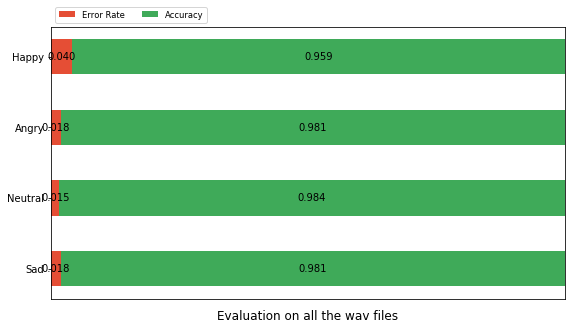

In [74]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on all the wav files'
results = {
    'Happy': [dictionary_all_h.get('error_rate'), dictionary_all_h.get('accuracy')],
    'Angry': [dictionary_all_a.get('error_rate'), dictionary_all_a.get('accuracy')],
    'Neutral': [dictionary_all_n.get('error_rate'), dictionary_all_n.get('accuracy')],
    'Sad': [dictionary_all_s.get('error_rate'), dictionary_all_s.get('accuracy')]
}

draw(results, category_names, graph_title)